In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.backend import backend

from __future__ import print_function

import os
import re

import numpy as np
import PIL
from PIL import Image

from scipy.stats import randint as sp_randint

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential,Model
from keras.layers import Dense, Convolution2D, AveragePooling2D, MaxPooling2D, Flatten, Activation, UpSampling2D, Add, merge, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing import image as im
from keras.callbacks import Callback

from keras.models import model_from_json

import tensorflow as tf
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

%matplotlib inline

    

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import glob
from skimage import color
import scipy

def preprocess_single_image(img_name, datagen=None, doRandomTransform=True):
    image = plt.imread(img_name)
    
    if image.shape[0] > image.shape[1]:
        offset = int((image.shape[0] - image.shape[1]) / 2 + 1)
        image = image[offset:image.shape[1]+offset,:,:]
    elif image.shape[0] < image.shape[1]:
        offset = int((image.shape[1] - image.shape[0]) / 2 + 1)
        image = image[:,offset:image.shape[0]+offset,:]

    #resize
    image = scipy.misc.imresize(image, (224, 224), interp='bilinear')
    
    #random transform using data generators functions
    if doRandomTransform:
        image = datagen.random_transform(image)
    
    return image

def preprocess_images(image_names, seed, datagen):
    np.random.seed(seed)
    images=[]
    for img_name in image_names:
        image = preprocess_single_image(img_name, datagen)
        images.append(image)
    return images



''' Convert color images to gray scales, color images to HUV format,
    return grayscale RGB image and UV channels of color image 
'''
def data_generator(image_name_path,batchsize):
    image_names = glob.glob(image_name_path)
    
    datagen_args = dict(rotation_range=10,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        
                    )
    datagen = ImageDataGenerator(**datagen_args)
    seed = 1000
    
    while 1:
        batch = np.random.choice(image_names, batchsize,replace=False)
        rgbImages = preprocess_images(batch,seed,datagen)
        grayScales = [ color.gray2rgb(color.rgb2gray(i)) for i in rgbImages]
        
        yuvColor = [ color.rgb2yuv(i) for i in rgbImages]
        #yuvGray = [ color.rgb2yuv(i) for i in grayScales]
        
        grayScale_arr = np.array(grayScales)
        
        #grayScale_arr = preprocess_input(grayScale_arr)
        #yuvGray_arr = np.array(yuvGray)
        #yuvGray_arr[:,:,:,1:] = 0
        
        yuvColor_arr = np.array(yuvColor)[:,:,:,1:]
        
        yield grayScale_arr, yuvColor_arr
    
    

In [4]:
with open('tanh_blur_2_deepConv_model.json','r') as json_file:
        loaded_model_json = json_file.read()

In [5]:
loaded_model = model_from_json(loaded_model_json)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:1206: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


these weights worked really well

In [ ]:
loaded_model.load_weights('checkpoints_uv_tanh_blur/backup/weights.26-0.00272.hdf5')

In [ ]:
#loaded_model.load_weights('checkpoints_uv_tanh_blur/weights.00-0.00280976.hdf5')
loaded_model.load_weights('checkpoints_uv_tanh_blur/weights.71-0.00220341.hdf5')


In [ ]:
loaded_model.load_weights('checkpoints_uv_tanh_blur/weights.04-0.00249.hdf5')


In [ ]:
loaded_model.load_weights('checkpoints_uv_tanh_blur/weights.01-0.00263.hdf5')


In [6]:

with open('tanh_blur_2_deepConv_model.json') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('checkpoints_uv_tanh_lessblur_deepConv/3pt_blur_weights.09-0.00222036.hdf5')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:1206: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [7]:
#colorImg=preprocess_single_image('data/validationImages/frame118000.jpg', ImageDataGenerator())
#colorImg=preprocess_single_image('data/validationImages/frame10250.jpg', ImageDataGenerator())
colorImg=preprocess_single_image('data/validationImages/ILSVRC2012_val_00000009.JPEG', ImageDataGenerator())
#colorImg=preprocess_single_image('data/validationImages/frame59750.jpg', ImageDataGenerator())

#plt.imshow(dat)

grayImg = color.rgb2gray(colorImg)
grayImg3Ch = np.zeros(colorImg.shape)
grayImg3Ch[:,:,0] = grayImg
grayImg3Ch[:,:,1] = grayImg
grayImg3Ch[:,:,2] = grayImg

yuvColorImg = color.rgb2yuv(colorImg)
yuvGrayImg = np.zeros(colorImg.shape)
yuvGrayImg[:,:,0] = yuvColorImg[:,:,0]

In [8]:
uvResult = loaded_model.predict(np.expand_dims(grayImg3Ch,0))
print(np.min(uvResult),np.max(uvResult))

-0.308639 0.352674


(-0.5, 0.5)

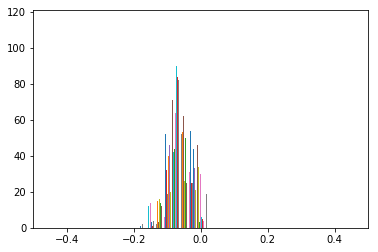

In [9]:
plt.hist(yuvColorImg[:,:,1])
plt.xlim(-.5,.5)

(-0.5, 0.5)

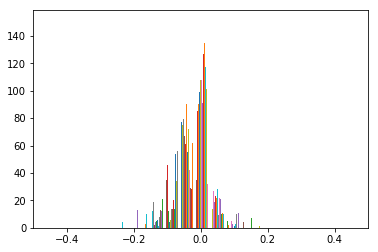

In [11]:
plt.hist(uvResult[0,:,:,0])
plt.xlim(-.5,0.5)

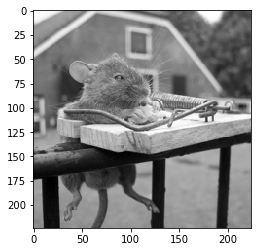

In [12]:
plt.imshow(color.rgb2gray(colorImg), cmap='gray')

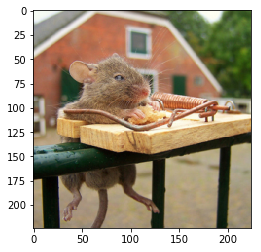

In [13]:
plt.imshow(colorImg[:,:,:])

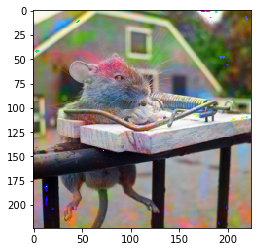

In [14]:
pred_YUVImg = np.zeros(colorImg.shape)
pred_YUVImg[:,:,0] = yuvColorImg[:,:,0]
pred_YUVImg[:,:,1] = uvResult[0,:,:,0] 
pred_YUVImg[:,:,2] = uvResult[0,:,:,1] 

pred_YUVImg[pred_YUVImg[:,:,1]>0.5,1] = 0.5
pred_YUVImg[pred_YUVImg[:,:,1]<(-0.5),1] = -0.5

pred_YUVImg[pred_YUVImg[:,:,2]>0.5,2] = 0.5
pred_YUVImg[pred_YUVImg[:,:,2]<(-0.5),2] = -0.5

plt.imshow(color.yuv2rgb(pred_YUVImg))

In [ ]:
pred_YUVImg = np.zeros(colorImg.shape)
pred_YUVImg[:,:,0] = yuvColorImg[:,:,0]
pred_YUVImg[:,:,1] = uvResult[0,:,:,0] 
pred_YUVImg[:,:,2] = uvResult[0,:,:,1] 

pred_YUVImg[pred_YUVImg[:,:,1]>0.5,1] = 0.5
pred_YUVImg[pred_YUVImg[:,:,1]<(-0.5),1] = -0.5

pred_YUVImg[pred_YUVImg[:,:,2]>0.5,2] = 0.5
pred_YUVImg[pred_YUVImg[:,:,2]<(-0.5),2] = -0.5

plt.imshow(color.yuv2rgb(pred_YUVImg))

In [ ]:
pred_YUVImg = np.zeros(colorImg.shape)
pred_YUVImg[:,:,0] = yuvColorImg[:,:,0]
pred_YUVImg[:,:,1] = uvResult[0,:,:,0] 
pred_YUVImg[:,:,2] = uvResult[0,:,:,1] 

pred_YUVImg[pred_YUVImg[:,:,1]>0.5,1] = 0.5
pred_YUVImg[pred_YUVImg[:,:,1]<(-0.5),1] = -0.5

pred_YUVImg[pred_YUVImg[:,:,2]>0.5,2] = 0.5
pred_YUVImg[pred_YUVImg[:,:,2]<(-0.5),2] = -0.5

plt.imshow(color.yuv2rgb(pred_YUVImg))

In [15]:
def uv2rgb(grayY,uv):
    pred_YUVImg = np.zeros((grayY.shape[0],grayY.shape[0],3))
    pred_YUVImg[:,:,0] = color.rgb2yuv(color.gray2rgb(grayY))[:,:,0]
    pred_YUVImg[:,:,1] = uv[:,:,0] 
    pred_YUVImg[:,:,2] = uv[:,:,1] 

    pred_YUVImg[pred_YUVImg[:,:,1]>0.5,1] = 0.5
    pred_YUVImg[pred_YUVImg[:,:,1]<(-0.5),1] = -0.5

    pred_YUVImg[pred_YUVImg[:,:,2]>0.5,2] = 0.5
    pred_YUVImg[pred_YUVImg[:,:,2]<(-0.5),2] = -0.5
    
    return color.yuv2rgb(pred_YUVImg)

#plt.imshow(uv2rgb(color.rgb2gray(colorImg), uvResult[0]))

In [16]:
def gray2Color(grays, model):
    modelInputs = [color.gray2rgb(i) for i in grays]
   
    modelOutputs = model.predict(np.array(modelInputs))
    
    #return [uv2rgb(grays[i,:,:], modelOutputs[i,:,:,:]) for i in range(modelOutputs.shape[0])]
    return [uv2rgb(grays[i], modelOutputs[i,:,:,:]) for i in range(modelOutputs.shape[0])]

In [17]:
#


resizedColorImgs =  [preprocess_single_image(i, 
                                           datagen=None, 
                                           doRandomTransform=False) for i in glob.glob('data/validationImages/*.JPEG')[100:150:10]]
grays = [color.rgb2gray(i) for i in resizedColorImgs]

predColors = gray2Color(grays, loaded_model)

In [1]:
with open('tanh_blur_model.json','r') as json_file:
        loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('checkpoints_uv_tanh_blur/backup/weights.26-0.00272.hdf5')

FileNotFoundError: [Errno 2] No such file or directory: 'tanh_blur_model.json'

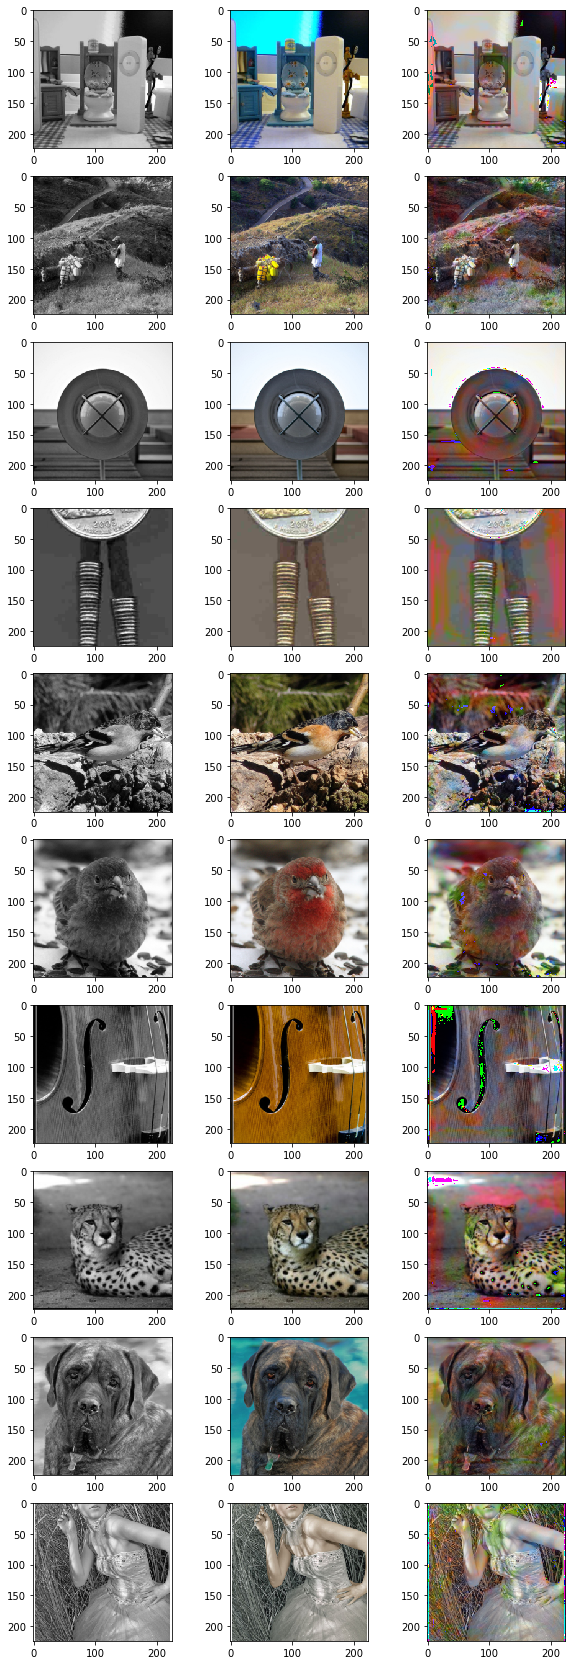

In [24]:
resizedColorImgs =  [preprocess_single_image(i, 
                                           datagen=None, 
                                           doRandomTransform=False) for i in glob.glob('data/validationImages/*.JPEG')[55:155:10]]
grays = [color.rgb2gray(i) for i in resizedColorImgs]

predColors = gray2Color(grays, loaded_model)

r = len(predColors)

fig,ax = plt.subplots(r,3,figsize=(10,3*r))

for i in range(len(predColors)):
    ax[i][0].imshow(grays[i], cmap='gray')
    ax[i][1].imshow(resizedColorImgs[i])
    ax[i][2].imshow(predColors[i])

In [ ]:
with open('tanh_blur_2_deepConv_model.json') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('checkpoints_uv_tanh_lessblur_deepConv/3pt_blur_weights.22-0.00369514.hdf5')

In [ ]:
resizedColorImgs =  [preprocess_single_image(i, 
                                           datagen=None, 
                                           doRandomTransform=False) for i in glob.glob('data/validationImages/*.jpg')[191:250:15]]
grays = [color.rgb2gray(i) for i in resizedColorImgs]

predColors = gray2Color(grays, loaded_model)

r = len(predColors)

fig,ax = plt.subplots(r,3,figsize=(10,3*r))

for i in range(len(predColors)):
    ax[i][0].imshow(grays[i], cmap='gray')
    ax[i][1].imshow(resizedColorImgs[i])
    ax[i][2].imshow(predColors[i])
    
plt.savefig('comparison.png', dpi=1000)

In [ ]:
with open('tanh_blur_2_deepConv_model.json') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('checkpoints_uv_tanh_lessblur_deepConv/3pt_blur_weights.08-0.00373682.hdf5')

resizedColorImgs =  [preprocess_single_image(i, 
                                           datagen=None, 
                                           doRandomTransform=False) for i in glob.glob('data/validationImages/*.jpg')[191:250:15]]
grays = [color.rgb2gray(i) for i in resizedColorImgs]

predColors = gray2Color(grays, loaded_model)

r = len(predColors)

fig,ax = plt.subplots(r,3,figsize=(10,3*r))
fig.tight_layout()

for i in range(len(predColors)):
    ax[i][0].imshow(grays[i], cmap='gray')
    ax[i][1].imshow(resizedColorImgs[i])
    ax[i][2].imshow(predColors[i])
    ax[i][2].get_xaxis().set_visible(False)
plt.savefig('comparison.png', dpi=1000)


In [ ]:
resizedColorImgs =  [preprocess_single_image(i, 
                                           datagen=None, 
                                           doRandomTransform=False) for i in glob.glob('data/validationImages/*.jpg')[100:150:10]]
grays = [color.rgb2gray(i) for i in resizedColorImgs]

predColors = gray2Color(grays, loaded_model)

In [ ]:
r = len(predColors)

fig,ax = plt.subplots(r,3,figsize=(10,3*r))

for i in range(len(predColors)):
    ax[i][0].imshow(grays[i], cmap='gray')
    ax[i][1].imshow(resizedColorImgs[i])
    ax[i][2].imshow(predColors[i])

In [ ]:
r = len(predColors)

fig,ax = plt.subplots(r,3,figsize=(10,3*r))

for i in range(len(predColors)):
    ax[i][0].imshow(grays[i], cmap='gray')
    ax[i][1].imshow(resizedColorImgs[i])
    ax[i][2].imshow(predColors[i])

In [ ]:
r = len(predColors)

fig,ax = plt.subplots(r,3,figsize=(10,3*r))

for i in range(len(predColors)):
    ax[i][0].imshow(grays[i], cmap='gray')
    ax[i][1].imshow(resizedColorImgs[i])
    ax[i][2].imshow(predColors[i])

In [ ]:
r = len(predColors)

fig,ax = plt.subplots(r,3,figsize=(10,3*r))

for i in range(len(predColors)):
    ax[i][0].imshow(grays[i], cmap='gray')
    ax[i][1].imshow(resizedColorImgs[i])
    ax[i][2].imshow(predColors[i])

In [ ]:
print(len(glob.glob('checkpoints_uv_tanh_blur/*.*')))
fig, ax = plt.subplots(7,5,figsize=(30,35))
count = 0
r=0
c=0
for i in glob.glob('checkpoints_uv_tanh_blur/*.*')[::]:
    loaded_model.load_weights(i)
    predColors = gray2Color(grays, loaded_model)[0]

    ax[r][c].imshow(predColors)
    ax[r][c].set_title(i)
    if c==4:
        r += 1
        c=0
    else:
        c +=1

In [ ]:
glob.glob('checkpoints_uv_tanh_blur/*.*')

In [ ]:
for i in glob.glob('checkpoints_uv_tanh_blur/*.*')[:10:]:
    predColors = gray2Color(grays, loaded_model)[0]
    
    resizedColorImgs =  [preprocess_single_image(i, 
                                           datagen=None, 
                                           doRandomTransform=False) for i in glob.glob('data/validationImages/*.jpg')[100:150:10]]
grays = [color.rgb2gray(i) for i in resizedColorImgs]

predColors = gray2Color(grays, loaded_model)

In [ ]:
import matplotlib.animation as animation
import numpy as np
from pylab import *


dpi = 100

def ani_frame():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    im = ax.imshow(,cmap='gray',interpolation='nearest')
    im.set_clim([0,1])
    fig.set_size_inches([5,5])


    tight_layout()


    def update_img(n):
        tmp = rand(300,300)
        im.set_data(tmp)
        return im

    #legend(loc=0)
    ani = animation.FuncAnimation(fig,update_img,300,interval=30)
    writer = animation.writers['ffmpeg'](fps=30)

    ani.save('demo.mp4',writer=writer,dpi=dpi)
    return ani

In [ ]:
pred_YUVImg